# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

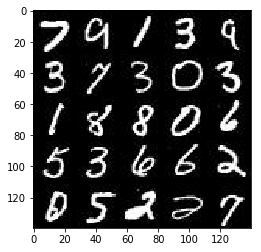

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

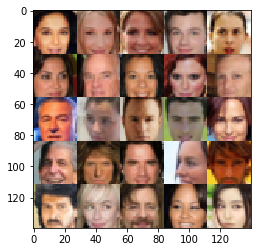

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x32
        
        conv2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        # 7x7x64
        
        conv3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        # 4x4x128
        
        conv4 = tf.layers.conv2d(relu3, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm4 = tf.layers.batch_normalization(conv4, training=True)
        relu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        # 2x2x256
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim,  is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    if is_train==True:
        reuse = False
    else:
        reuse = True

    with tf.variable_scope("generator", reuse=reuse):
        # First fully connected layer
        fc1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        reshape = tf.reshape(fc1, (-1, 4, 4, 512))
        batch_norm1 = tf.layers.batch_normalization(reshape, training=is_train)
        lrelu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        # 4x4x512

        deconv1 = tf.layers.conv2d_transpose(lrelu1, 128, 4, strides=1, padding='valid')
        batch_norm2 = tf.layers.batch_normalization(deconv1, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        # 7x7x128
        
        deconv2 = tf.layers.conv2d_transpose(lrelu2, 64, 5, 2, 'same')
        batch_norm3 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        # 14x14x64
        
        deconv3 = tf.layers.conv2d_transpose(lrelu3, 32, 5, 2, 'same')
        batch_norm4 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        # 28x28x32
        
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 3, 1, 'same')
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Build the model
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    if data_image_mode == "L":
        out_channel_dim = 1
    else:
        out_channel_dim = 3
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt,
                             feed_dict={input_z: batch_z,
                                        input_real: batch_images,
                                        learn_rate: learning_rate})
                _ = sess.run(g_train_opt, 
                             feed_dict={input_z: batch_z, 
                                        input_real: batch_images,
                                        learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train = False),
                                   feed_dict={input_z: batch_z})
                    
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8043... Generator Loss: 1.1347
Epoch 1/2... Discriminator Loss: 2.1996... Generator Loss: 4.2074
Epoch 1/2... Discriminator Loss: 0.3948... Generator Loss: 8.9499
Epoch 1/2... Discriminator Loss: 0.4447... Generator Loss: 2.6243
Epoch 1/2... Discriminator Loss: 0.5515... Generator Loss: 2.0980
Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 5.1395
Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 3.5119
Epoch 1/2... Discriminator Loss: 2.9366... Generator Loss: 0.0991
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 2.5572
Epoch 1/2... Discriminator Loss: 1.6537... Generator Loss: 3.2868


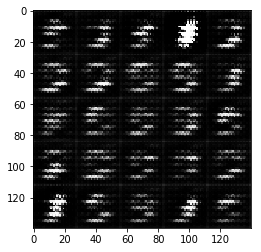

Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.7824
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 1.2688
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 3.6809
Epoch 1/2... Discriminator Loss: 1.9013... Generator Loss: 2.7207
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.9581
Epoch 1/2... Discriminator Loss: 0.6822... Generator Loss: 1.3829
Epoch 1/2... Discriminator Loss: 0.8566... Generator Loss: 1.2907
Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 2.0726
Epoch 1/2... Discriminator Loss: 2.0222... Generator Loss: 0.2720
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.7085


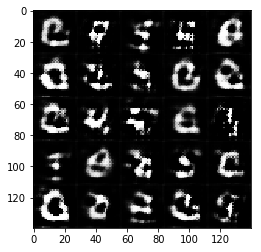

Epoch 1/2... Discriminator Loss: 1.0594... Generator Loss: 1.2648
Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 1.2117
Epoch 1/2... Discriminator Loss: 1.0302... Generator Loss: 0.9259
Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 0.8068
Epoch 1/2... Discriminator Loss: 1.3103... Generator Loss: 1.2449
Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 1.3138
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 0.5806


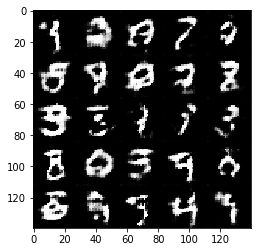

Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 1.0848
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.8456... Generator Loss: 0.2864
Epoch 1/2... Discriminator Loss: 1.0130... Generator Loss: 1.4257
Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 1.3922
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 1.4323
Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 1.2170
Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 1.3379
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 0.9525


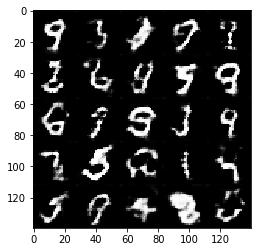

Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 0.8493
Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 1.0542
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 0.9764... Generator Loss: 1.0322
Epoch 1/2... Discriminator Loss: 1.4925... Generator Loss: 2.5845
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 1.5402
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.7228
Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 0.9592


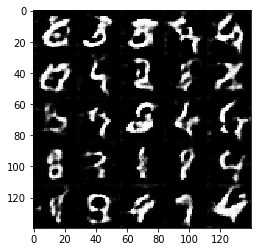

Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 0.9981... Generator Loss: 0.9746
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 0.8930
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 0.5223
Epoch 1/2... Discriminator Loss: 1.5998... Generator Loss: 1.3113
Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 1.3946
Epoch 1/2... Discriminator Loss: 0.9886... Generator Loss: 1.6101
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 0.6050


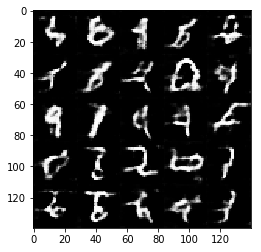

Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 0.6643
Epoch 1/2... Discriminator Loss: 1.1383... Generator Loss: 1.1916
Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 1.6783
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 0.8338
Epoch 1/2... Discriminator Loss: 0.9070... Generator Loss: 1.1308
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.4710... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 0.9639
Epoch 1/2... Discriminator Loss: 1.2620... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 1.0028


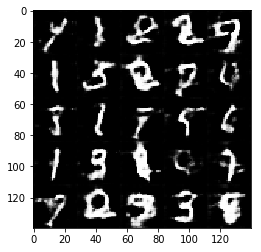

Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 1.1411
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 1.8965
Epoch 1/2... Discriminator Loss: 1.7042... Generator Loss: 2.0356
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 1.4307
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.0612
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 0.8198
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.5069
Epoch 1/2... Discriminator Loss: 0.8771... Generator Loss: 1.3053
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 1.5692
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.8867


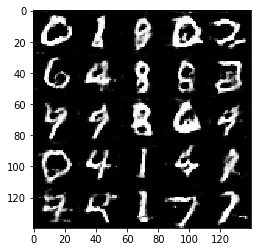

Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.2323
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.6327
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 1.1132
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.5378
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.6106
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 1.0349
Epoch 1/2... Discriminator Loss: 1.0836... Generator Loss: 2.2127
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 0.7636


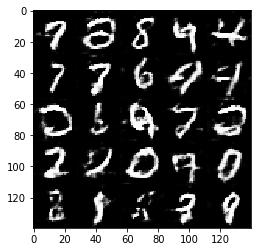

Epoch 1/2... Discriminator Loss: 1.0564... Generator Loss: 0.8423
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.5243
Epoch 2/2... Discriminator Loss: 1.6112... Generator Loss: 0.3720
Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 0.7769
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 1.2376
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 1.8239
Epoch 2/2... Discriminator Loss: 0.9663... Generator Loss: 1.7881
Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 0.6413


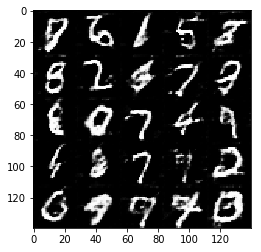

Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.2334
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 1.5069
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 0.7699
Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 1.3146
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 0.8324
Epoch 2/2... Discriminator Loss: 1.5245... Generator Loss: 1.8661
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 0.8927
Epoch 2/2... Discriminator Loss: 1.1416... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 0.7928


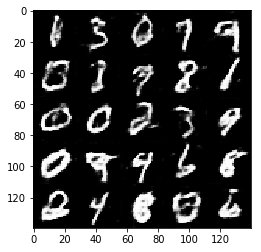

Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 0.7648
Epoch 2/2... Discriminator Loss: 1.7179... Generator Loss: 2.9987
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.9709
Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 1.4402
Epoch 2/2... Discriminator Loss: 1.0702... Generator Loss: 1.7634
Epoch 2/2... Discriminator Loss: 1.6425... Generator Loss: 0.4079
Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 1.2195
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 0.8338
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 0.6813


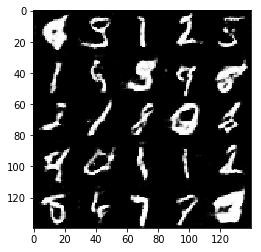

Epoch 2/2... Discriminator Loss: 1.1782... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.4822
Epoch 2/2... Discriminator Loss: 1.7777... Generator Loss: 0.3330
Epoch 2/2... Discriminator Loss: 0.7536... Generator Loss: 1.3709
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.1576
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 1.3485
Epoch 2/2... Discriminator Loss: 2.1005... Generator Loss: 0.2562
Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 0.7489
Epoch 2/2... Discriminator Loss: 1.6929... Generator Loss: 0.3672


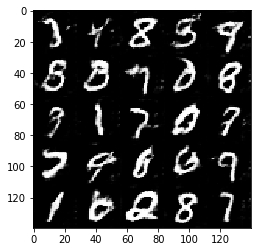

Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.5333
Epoch 2/2... Discriminator Loss: 0.9222... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 0.9429... Generator Loss: 0.9877
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 1.7193... Generator Loss: 2.8984
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 1.3309
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 1.2499
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.7447


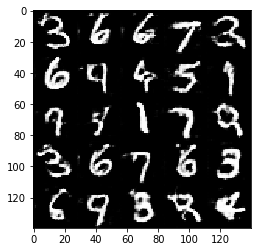

Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 1.8213
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.1789
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 0.5675
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 0.9679
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 1.4552
Epoch 2/2... Discriminator Loss: 2.4714... Generator Loss: 0.1771
Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 1.6407
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 1.3385


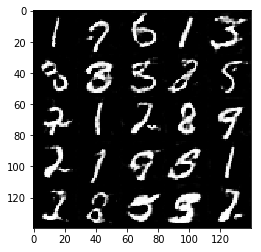

Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 0.9169
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 0.7130
Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.9206... Generator Loss: 0.3307
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 1.2442
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.4506
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 0.7219
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.2985
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.5812


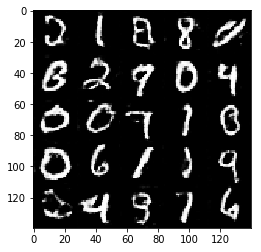

Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 1.2351
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.1099... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 1.5372... Generator Loss: 0.4727
Epoch 2/2... Discriminator Loss: 1.8035... Generator Loss: 0.3242
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 0.9298
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 1.2376
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 0.9080


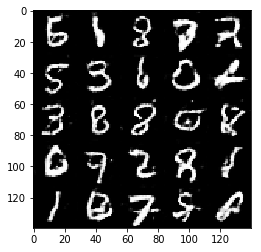

Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 1.8782
Epoch 2/2... Discriminator Loss: 0.9489... Generator Loss: 1.2930
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 0.8690
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 1.2586
Epoch 2/2... Discriminator Loss: 1.0128... Generator Loss: 1.1782
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 0.7266
Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.9354... Generator Loss: 0.3002
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.5113
Epoch 2/2... Discriminator Loss: 1.9991... Generator Loss: 0.2773


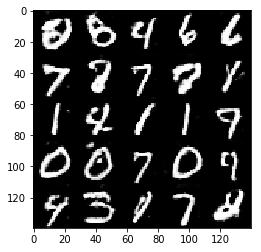

Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 0.9652
Epoch 2/2... Discriminator Loss: 1.8989... Generator Loss: 0.2803
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 0.9693
Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 0.9145
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 1.1366
Epoch 2/2... Discriminator Loss: 1.4464... Generator Loss: 0.5621
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 0.9417


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.7844
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 1.9039
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 2.1080
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.6273
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 5.4144
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 1.6466
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 3.9858
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.4484


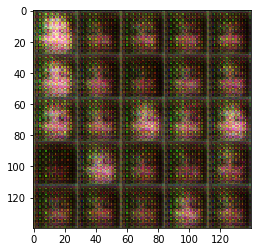

Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 3.4849
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 2.3829
Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 2.3531
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 3.3228
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.9836... Generator Loss: 0.2623
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.3258
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.9613
Epoch 1/1... Discriminator Loss: 2.0390... Generator Loss: 0.2468


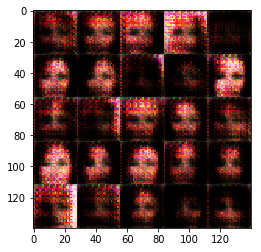

Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.7262
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.4697
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.3931
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.4672
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.4508
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.5589
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 2.7412
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.4548


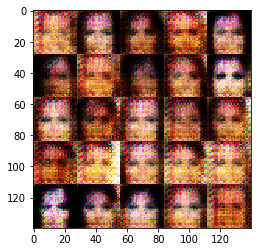

Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.8865
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 2.3193
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.4792
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 1.8551
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.6131


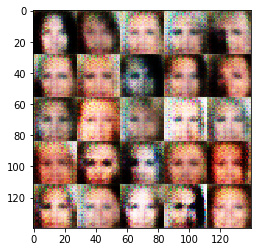

Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.1764
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.7251
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.3387
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.6789


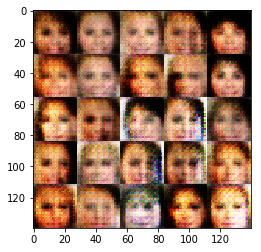

Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 1.6294


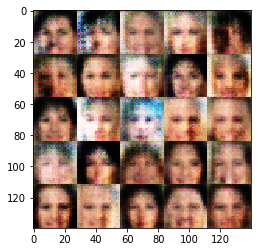

Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.4379
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 1.2914
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.4421


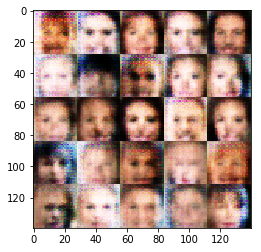

Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.3251
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.6649
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.2395


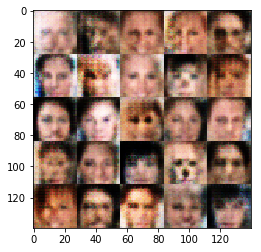

Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.4778
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.7524
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 1.2649
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 1.1168


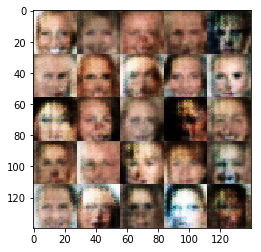

Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.4211
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 1.6744


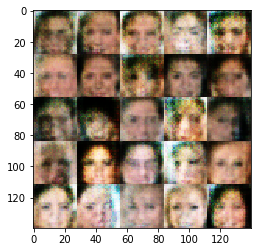

Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.1213
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.8234


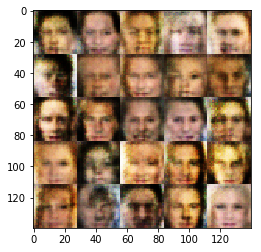

Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 1.3970
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.3170
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.2939


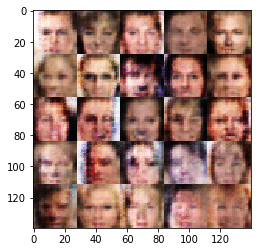

Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.2034
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.1999
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.9669


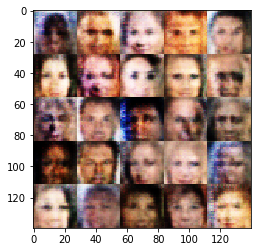

Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.1306


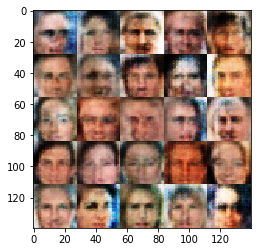

Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6764


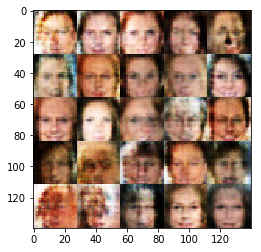

Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 1.2331
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.2059
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.0457


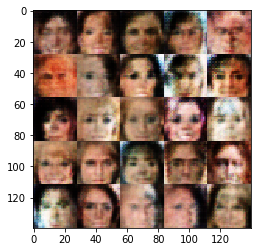

Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 1.4471
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.1623
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.4196
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.7896


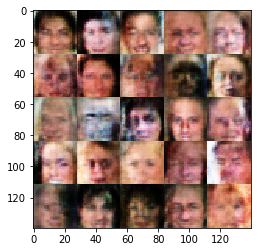

Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.5637
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.4259


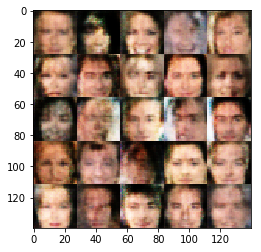

Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.5489
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.8889


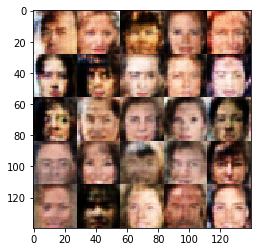

Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 1.8615
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.1459
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 1.4631
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 3.0290


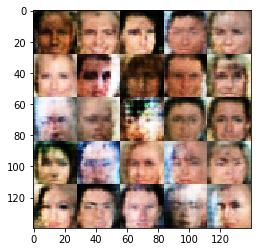

Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 1.7173... Generator Loss: 0.3181
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.8485


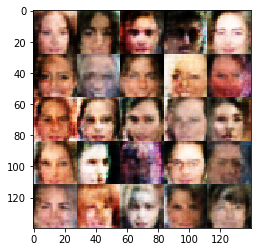

Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.6175


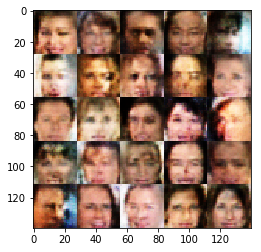

Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.3036
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 1.6005
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 2.4944
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.5969
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.7438


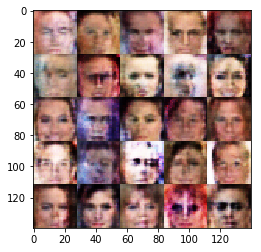

Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.4955
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 2.1466


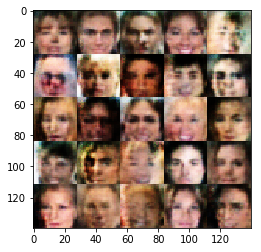

Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.2409
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.6908
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.3603
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.2289


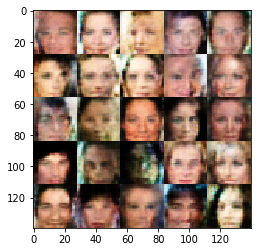

Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.5227
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.3937
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 2.6012
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.8605
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.8148


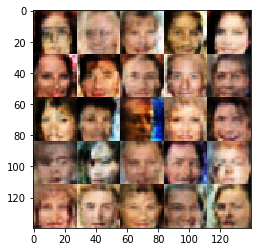

Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.3408
Epoch 1/1... Discriminator Loss: 1.8818... Generator Loss: 2.8090
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.5402
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 2.7092
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 3.8259


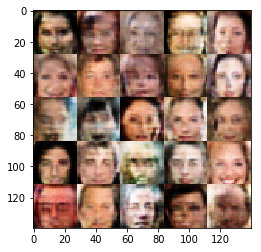

Epoch 1/1... Discriminator Loss: 0.6118... Generator Loss: 1.9036
Epoch 1/1... Discriminator Loss: 0.5894... Generator Loss: 1.6840
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 1.7014
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 1.6233
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.5210
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 2.2025
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.6007


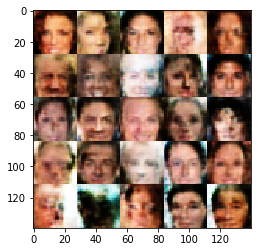

Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 2.9101
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 2.2731
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 2.2559
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.7259
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.9142
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.3914
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.1583


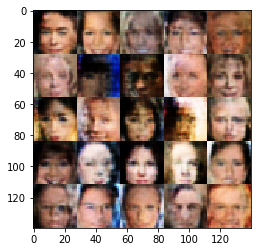

Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 2.0415
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.2984
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 1.9361
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 1.8397
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.5929


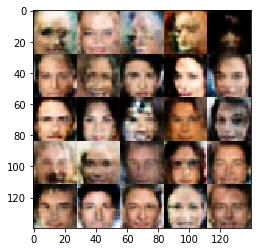

Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 3.5597
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.7689
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 3.4004
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 0.7196... Generator Loss: 1.5119
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.6332


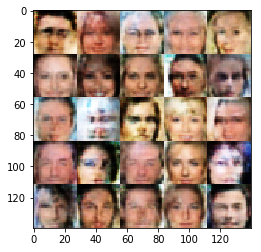

Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.6939
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 2.1899
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.5195
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 2.3678
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 1.5810


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.